## Imports and Definitions

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [3]:
# A custom metric we use to get a better representation of accuracy, one that
# accounts for class imbalance (weights accuracy equally across classes)

class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name="balanced_sparse_categorical_accuracy", dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

# Retrieving/Visualizing Data

In [4]:
data_path_train = '/content/drive/My Drive/Brain_Tumor_Project/ViT-Tumor-Classification-master/dataset/training' #use correct data path'
data_path_test = '/content/drive/My Drive/Brain_Tumor_Project/ViT-Tumor-Classification-master/dataset/testing' #use correct data path'

path_train = pathlib.Path(data_path_train)
path_test = pathlib.Path(data_path_test)
train_data = len(list(path_train.glob('*/*.jpg')))
print('Size of Training Data: ', train_data)
test_data = len(list(path_test.glob('*/*.jpg')))
print('Size of Testing Data: ',test_data)

Size of Training Data:  5712
Size of Testing Data:  1311


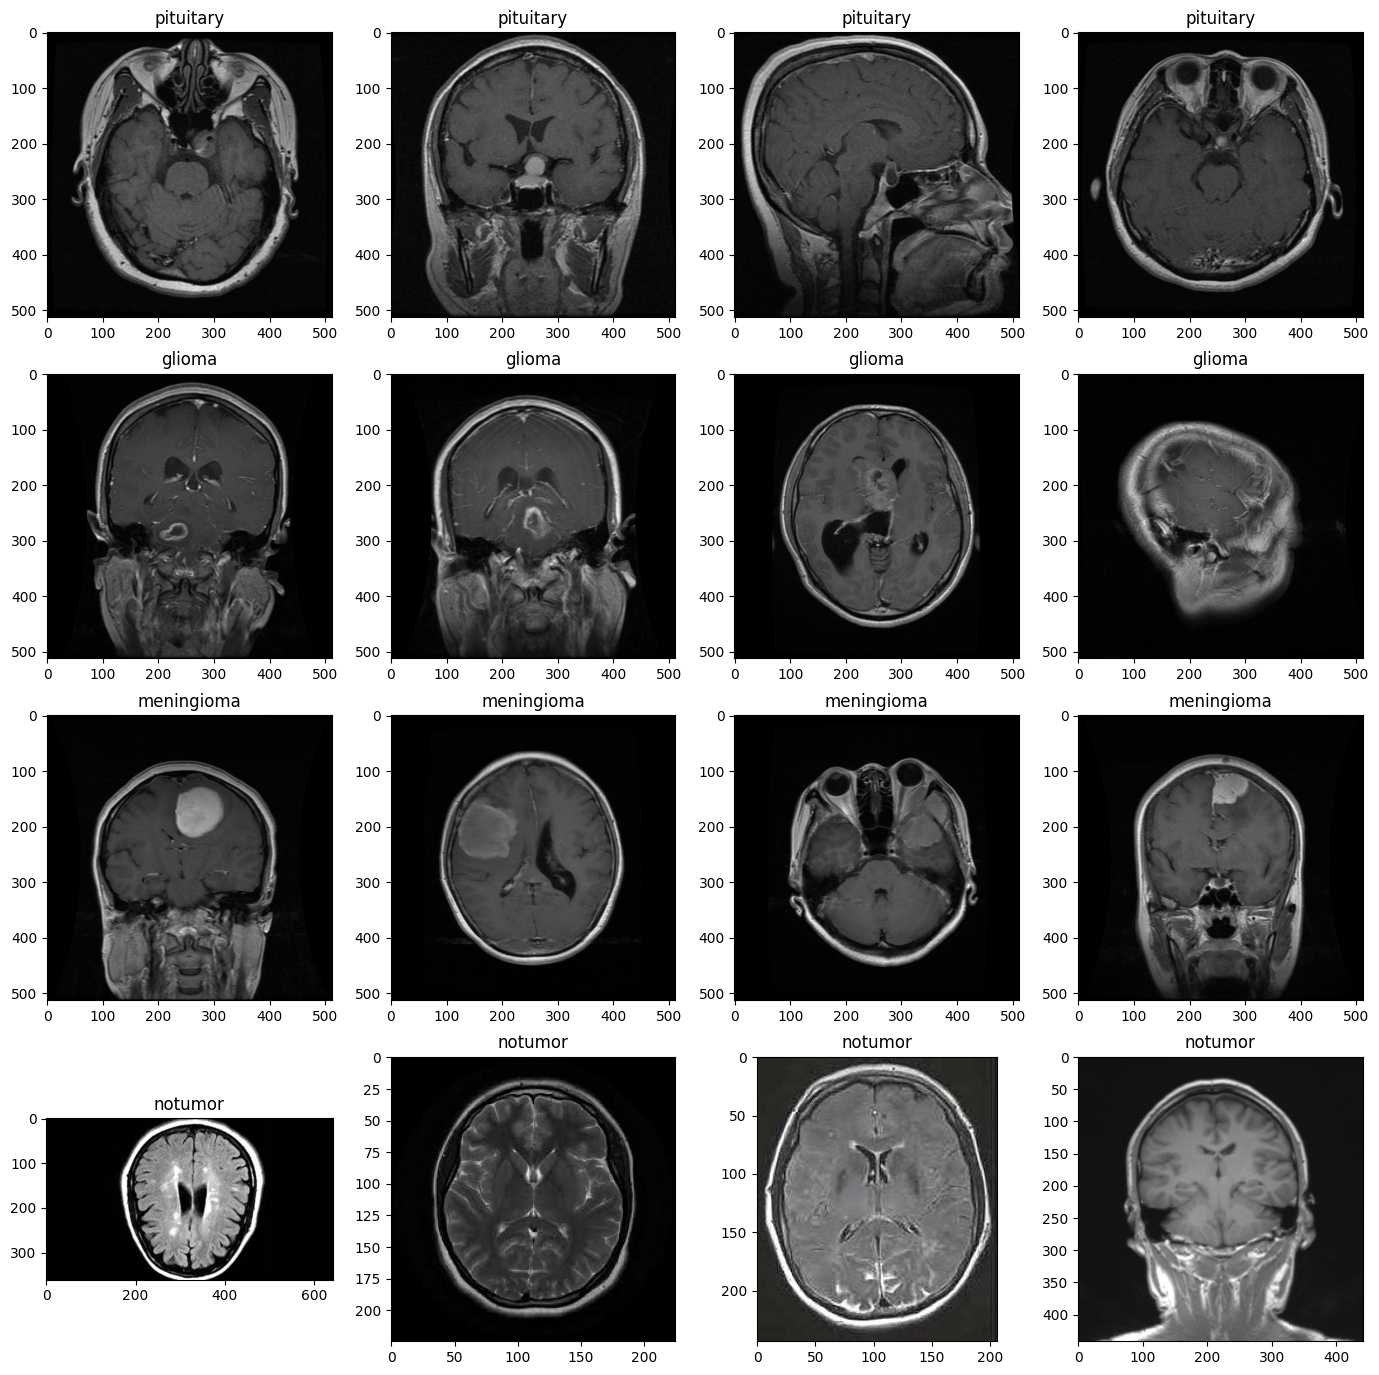

In [5]:
classes = os.listdir(data_path_train)
files_path_dict = {}

for c in classes:
    path = os.path.join(data_path_train, c)
    if os.path.isdir(path):
        files_path_dict[c] = [os.path.join(path, x) for x in os.listdir(path)]

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

# Showing some of the training images


# Preprocessing

In [6]:
input_info = {
    "image_size":(64, 64, 3),
    "n_classes":4,
    "batch_size":64,
}

In [7]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_path_train,
                                                            validation_split = 0.2,
                                                            subset = 'training',
                                                            seed = 42,
                                                            image_size = input_info["image_size"][:-1],
                                                            batch_size = input_info["batch_size"])

val = tf.keras.preprocessing.image_dataset_from_directory(data_path_train,
                                                          validation_split = 0.2,
                                                          subset = 'validation',
                                                          seed = 42,
                                                          image_size = input_info["image_size"][:-1],
                                                          batch_size = input_info["batch_size"])

test = tf.keras.preprocessing.image_dataset_from_directory(data_path_test,
                                                           seed = 42,
                                                           image_size = input_info["image_size"][:-1],
                                                           batch_size = input_info["batch_size"])

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


## Training without Hyperparameter/Architectural Tuning

In [42]:
vgg16 = VGG16(input_shape = input_info["image_size"], weights = 'imagenet', classes = input_info["n_classes"], include_top=False)
# Freeze the pre-trained layers
vgg16.trainable = False
# Add custom top layers for training
model = vgg16.output
model = GlobalAveragePooling2D()(model)
model = Dense(1024, activation='relu')(model)
model = Dense(512, activation='relu')(model)
model = Dropout(0.5)(model)
output = Dense(4)(model)
model = Model(inputs = vgg16.input, outputs=output)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [43]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy", BalancedSparseCategoricalAccuracy()])
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
72/72 [==============================] - 23s 256ms/step - loss: 1.9257 - accuracy: 0.6726 - balanced_sparse_categorical_accuracy: 0.6656 - val_loss: 0.4831 - val_accuracy: 0.8354 - val_balanced_sparse_categorical_accuracy: 0.8184
Epoch 2/10
72/72 [==============================] - 28s 368ms/step - loss: 0.4699 - accuracy: 0.8199 - balanced_sparse_categorical_accuracy: 0.8148 - val_loss: 0.4192 - val_accuracy: 0.8599 - val_balanced_sparse_categorical_accuracy: 0.8560
Epoch 3/10
72/72 [==============================] - 21s 272ms/step - loss: 0.3545 - accuracy: 0.8667 - balanced_sparse_categorical_accuracy: 0.8615 - val_loss: 0.3946 - val_accuracy: 0.8643 - val_balanced_sparse_categorical_accuracy: 0.8528
Epoch 4/10
72/72 [==============================] - 24s 300ms/step - loss: 0.3037 - accuracy: 0.8810 - balanced_sparse_categorical_accuracy: 0.8754 - val_loss: 0.3992 - val_accuracy: 0.8660 - val_balanced_sparse_categorical_accuracy: 0.8516
Epoch 5/10
72/72 [==================

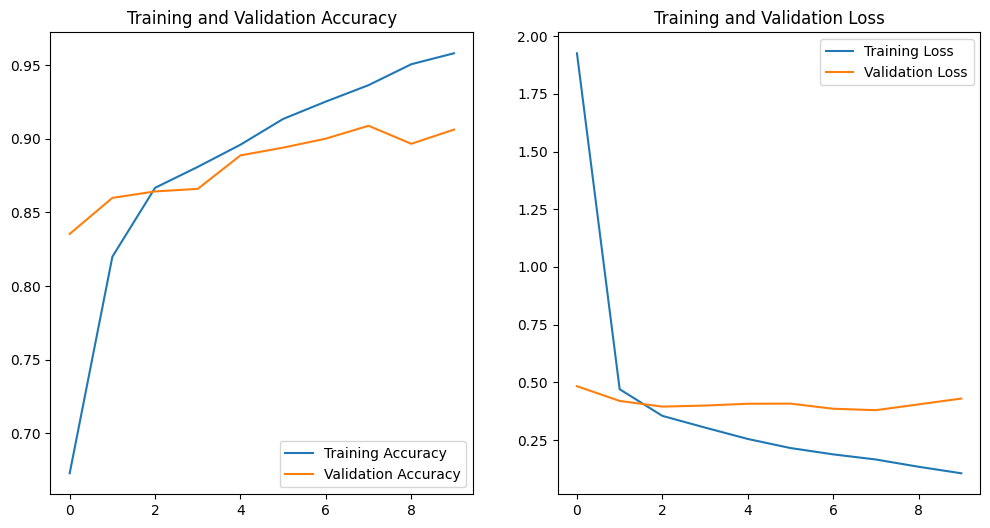

In [44]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Initial balanced accuracy on validation set : 0.900


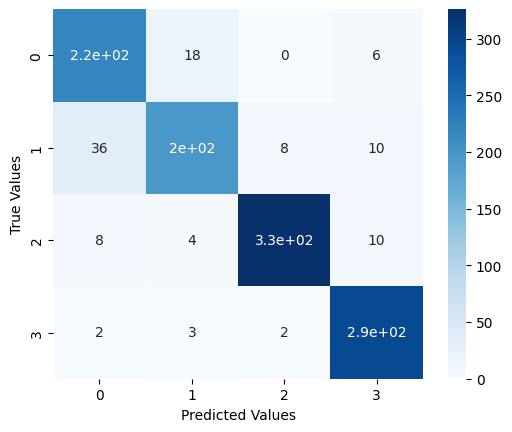

In [45]:
X, y_true = list(zip(*[(X, y) for (X, y) in val.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
sns.heatmap(mat, square=True, annot=True, cbar=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Initial balanced accuracy on validation set : {acc:.3f}")

## Hyperparameter and Architectural Tuning Through Repetitive Training

In [8]:
def train_model_and_get_val_acc(amt_neurons, l_rate, dropout_rate):
    # Use a pretrained vg16 model
    vgg16 = VGG16(input_shape = input_info["image_size"], weights = 'imagenet', classes = input_info["n_classes"], include_top=False)
    # Freeze the pre-trained layers
    vgg16.trainable = False
    # Add custom top layers for training
    model = vgg16.output
    model = GlobalAveragePooling2D()(model)
    model = Dense(1024, activation='relu')(model)
    model = Dense(512 if amt_neurons != "large" else 1024, activation='relu')(model)
    model = Dropout(dropout_rate)(model)
    output = Dense(4)(model)
    model = Model(inputs = vgg16.input, outputs=output)

    num_epochs = 30 if l_rate==0.0002 else 10

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=l_rate), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy", BalancedSparseCategoricalAccuracy()])
    model.fit(train, epochs=num_epochs, validation_data=val, verbose=0)
    X, y_true = list(zip(*[(X, y) for (X, y) in val.unbatch().as_numpy_iterator()]))
    y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
    val_acc = balanced_accuracy_score(y_true, y_hat)

    return model, val_acc, amt_neurons, l_rate, dropout_rate, num_epochs

In [9]:
amts_neurons = ["small", "large"]
l_rates = [0.001, 0.0002]
dropout_rates = [0.5, 0.35, 0.2]

In [10]:
best_result = None

for amt_neurons in amts_neurons:
    for l_rate in l_rates:
        for dropout_rate in dropout_rates:
            result = train_model_and_get_val_acc(amt_neurons=amt_neurons, l_rate=l_rate, dropout_rate=dropout_rate)
            if best_result is None or result[1] > best_result[1]: # looking for the best balanced validation accuracy
                best_result = result



In [34]:
best_model = best_result[0]
best_val_acc = best_result[1]

print("We achieved",best_result[1], "validation accuracy using, after the VGG16 pre-trained model and pooling layer,",
      "a dense layer of 1024 neurons\nfollowed by a dense layer of 512 (instead of 1024) neurons," if best_result[2] == "small" else "two dense layers of 1024 neurons,",
      "a dropout rate of", best_result[4], "afterwards, and a learning rate of", best_result[3], "all over", best_result[5], "epochs.\nThis was the best combination of",
      "hyperparameters that we found out of the ones we tested.")

We achieved 0.9315962912063036 validation accuracy using, after the VGG16 pre-trained model and pooling layer, a dense layer of 1024 neurons
followed by a dense layer of 512 (instead of 1024) neurons, a dropout rate of 0.2 afterwards, and a learning rate of 0.0002 all over 30 epochs.
This was the best combination of hyperparameters that we found out of the ones we tested.


## Retraining with Optimized Model

In [38]:
vgg16 = VGG16(input_shape = input_info["image_size"], weights = 'imagenet', classes = input_info["n_classes"], include_top=False)
# Freeze the pre-trained layers
vgg16.trainable = False
# Add custom top layers for training
model = vgg16.output
model = GlobalAveragePooling2D()(model)
model = Dense(1024, activation='relu')(model)
model = Dense(512, activation='relu')(model)
model = Dropout(0.2)(model)
output = Dense(4)(model)
model = Model(inputs = vgg16.input, outputs=output)
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [39]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy", BalancedSparseCategoricalAccuracy()])
history = model.fit(train, epochs=30, validation_data=val, verbose=1)

Epoch 1/30
72/72 [==============================] - 21s 239ms/step - loss: 1.4459 - accuracy: 0.6766 - balanced_sparse_categorical_accuracy: 0.6731 - val_loss: 0.5656 - val_accuracy: 0.8144 - val_balanced_sparse_categorical_accuracy: 0.8044
Epoch 2/30
72/72 [==============================] - 21s 267ms/step - loss: 0.5348 - accuracy: 0.8197 - balanced_sparse_categorical_accuracy: 0.8137 - val_loss: 0.5183 - val_accuracy: 0.8257 - val_balanced_sparse_categorical_accuracy: 0.8157
Epoch 3/30
72/72 [==============================] - 24s 303ms/step - loss: 0.3619 - accuracy: 0.8707 - balanced_sparse_categorical_accuracy: 0.8689 - val_loss: 0.4226 - val_accuracy: 0.8687 - val_balanced_sparse_categorical_accuracy: 0.8544
Epoch 4/30
72/72 [==============================] - 20s 250ms/step - loss: 0.2689 - accuracy: 0.9018 - balanced_sparse_categorical_accuracy: 0.8989 - val_loss: 0.3904 - val_accuracy: 0.8827 - val_balanced_sparse_categorical_accuracy: 0.8713
Epoch 5/30
72/72 [==================

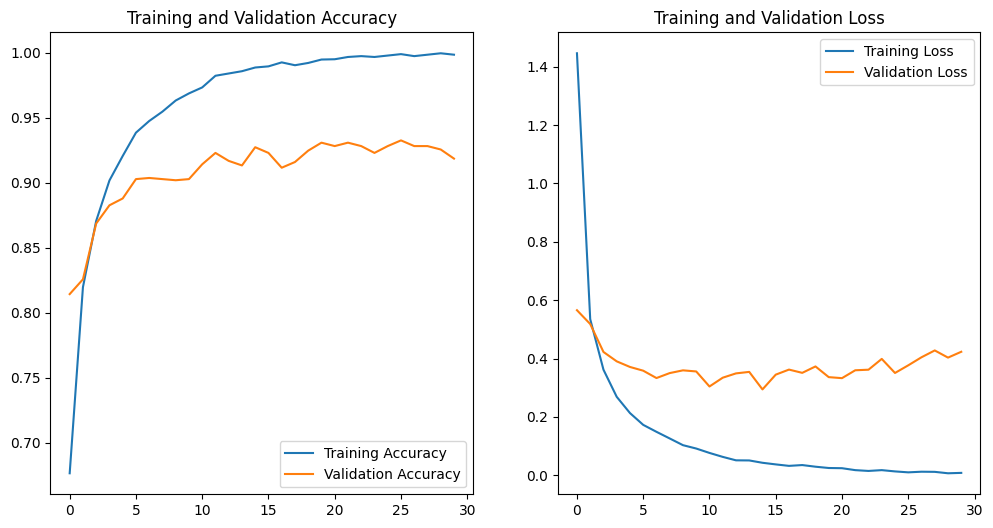

In [40]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 30

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Final balanced accuracy on validation set : 0.914


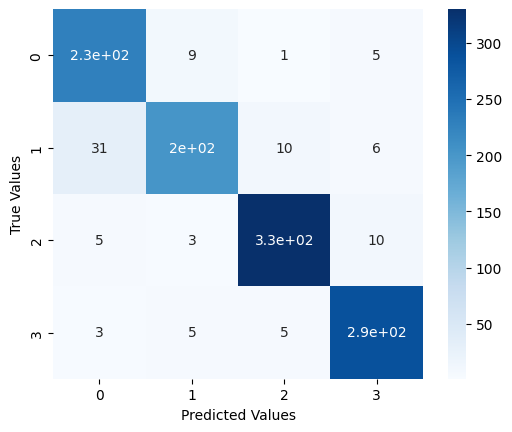

In [41]:
X, y_true = list(zip(*[(X, y) for (X, y) in val.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
sns.heatmap(mat, square=True, annot=True, cbar=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final balanced accuracy on validation set : {acc:.3f}")

# Testing

21/21 [==============================] - 259s 7s/step - loss: 0.3056 - accuracy: 0.9367 - balanced_sparse_categorical_accuracy: 0.9324


Text(77.92222222222227, 0.5, 'True Values')

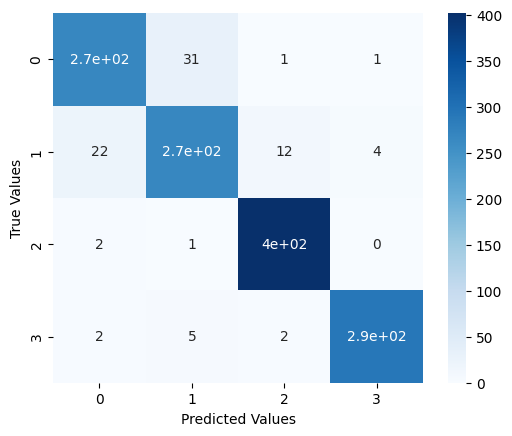

In [13]:
model.evaluate(test)
X, y_true = list(zip(*[(X, y) for (X, y) in test.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
sns.heatmap(mat, square=True, annot=True, cbar=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

In [36]:
test_acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final balanced accuracy on testing set : {test_acc:.3f}")

Final balanced accuracy on testing set : 0.932


Optimization through hyperparameter/architectural tuning gave us a 1.4% improvement on balanced validation accuracy, which likely allowed us to obtain higher testing accuracy than otherwise possible. We justify our specific optimization choices and architecture in the report.